<a href="https://colab.research.google.com/github/Yuvraj-Dhepe/uni_ml/blob/main/dida_task/Dida_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading G-Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Importing and Installing the required Libraries

In [2]:
!pip install albumentations
!apt remove git -y
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git git-lfs
0 upgraded, 0 newly installed, 2 to remove and 24 not upgraded.
After this operation, 47.9 MB disk space will be freed.
(Reading database ... 122519 files and directories currently installed.)
Removing git-lfs (2.9.2-1) ...
Removing git (1:2.25.1-1ubuntu3.11) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  gettext-base git-daemon-run | git-daemon-sysvinit git-doc git-el git-email
  git-gui gitk gitweb git-cvs git-mediawiki git-svn
The following NEW packages will be installed:
  git
0 up

In [3]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from skimage.transform import resize
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import euclidean
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16, MobileNetV2
from examples.tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,GlobalMaxPooling2D,\
 GlobalAveragePooling2D, Conv2DTranspose, ZeroPadding2D, concatenate, Input, Activation, Dropout

In [4]:
%cd /content/gdrive/MyDrive/images/Dida_task

/content/gdrive/MyDrive/images/Dida_task


## Utility Functions

### Preprocessing Functions

#### Changing Image Numbers for better tracking Function

In [ ]:
# # Set the path to your train directories
# train_image_path = '/content/gdrive/MyDrive/images/dida_task/train/images'
# train_label_path = '/content/gdrive/MyDrive/images/dida_task/train/labels'

# # Rename the image files
# image_files = sorted(os.listdir(train_image_path))
# for i, file in enumerate(image_files):
#     src = os.path.join(train_image_path, file)
#     dst = os.path.join(train_image_path, f"{i+1}.png")
#     os.rename(src, dst)

# # Rename the label files
# label_files = sorted(os.listdir(train_label_path))
# for i, file in enumerate(label_files):
#     src = os.path.join(train_label_path, file)
#     dst = os.path.join(train_label_path, f"{i+1}.png")
#     os.rename(src, dst)

#### Image Loading and Preprocessing Functions

In [ ]:
def train_test_img_loader(path: list[str], size:int)-> np.array:
  '''
  Basic loading of images and resizing it.
  '''
  image_files = sorted(os.listdir(path))
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = resize(image, (size,size))
    images.append(resized_image)
  return np.array(images)

def label_img_loader(path:list[str],size:int)-> np.array:
  '''
  Basic loading of labels in grayscale and resizing it.
  '''
  image_files = sorted(os.listdir(path))
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    gray_label = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized_label = resize(gray_label, (size,size))
    extended_image = tf.expand_dims(resized_label, axis = -1)
    binary_image = np.where(extended_image>0.5,1,0) # Binary Masking for the pixels, any pixel value greater than 0.5 is considered as part of roof else not roof.
    #thr_label = (resized_label > 0.45).astype('float32') # Binary Masking for the pixels, any pixel value greater than 0.5 is considered as part of roof else not roof.
    images.append(binary_image)
  return np.array(images)

#### Image Augmentation Function

In [ ]:
def augment_images(images, labels, num_aug=6):
  '''
  Per image this function generates num_aug images
  '''
  # Define the transforms to apply on both the images and the labels
  transforms = A.Compose([
      A.Resize(224, 224,interpolation = cv2.INTER_NEAREST), #Interpolation of image to preserve pixel values
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Rotate(limit=45, p=0.5),
      #A.Normalize(),
      #A.RandomScale(0.1)
  ])

  # Get the list of images and labels
  images_list = images
  labels_list = labels
  aug_image_list = np.empty((0,224,224,3),dtype = np.uint8)
  aug_label_list = np.empty((0,224,224,1),dtype = np.uint8)

  # Apply the transforms to each image and label pair and display them

  for i in range(len(images_list)):
    # Load the image and label and put it in our augmented list
    image = images_list[i]
    label = labels_list[i]
    aug_image_list = np.append(aug_image_list,[image],axis = 0)
    aug_label_list = np.append(aug_label_list,[label],axis = 0)

    for j in range(num_aug):
      # Apply the transforms to both the image and the label
      transformed = transforms(image=image, mask=label)
      image_transformed = transformed['image']
      label_transformed = transformed['mask']
      
      aug_image_list = np.append(aug_image_list,[image_transformed],axis = 0)
      aug_label_list = np.append(aug_label_list,[label_transformed],axis = 0)
  
  return aug_image_list, aug_label_list

#### Return Images to model.fit Function

In [ ]:
def img(ip_type = 'augmented'):
  '''
   Returns the images to the fit function
   @param: ip_type: Image Set to be Returned either normal images or augmented images
  '''
  if ip_type == 'normal':
    return processed_train_images,processed_train_labels,processed_val_images, processed_val_labels
  elif ip_type== 'augmented':
    return train_aug_images, train_aug_labels, val_aug_images, val_aug_labels

### Metrics Functions

#### Cross Validation Scores Generating Function

In [ ]:
def cv(model,folds,dataset):
  #Defining a model
  
  imgs = img(dataset)
  # Load your data
  X = imgs[0]
  y = imgs[1]

  # Define the K-Fold cross-validation iterator
  kfold = KFold(n_splits=folds, shuffle=False, random_state=None)
  scores =  []
  fold_indices = []

  for train_index, val_index in kfold.split(X):
      fold_indices.append((train_index, val_index))

  # Perform cross-validation
  for fold, (train_indices, val_indices) in enumerate(fold_indices):
      model = model
      print(f"Fold {fold+1}:")

      # Split the data into training and validation sets
      X_train, y_train = X[train_indices], y[train_indices]
      X_val, y_val = X[val_indices], y[val_indices]

      # Fit the model on the training set
      model.fit(X_train, y_train, epochs=15, batch_size=5, validation_data=(X_val, y_val), verbose=0)
      
      # Evaluate the model on the validation set
      score = model.evaluate(X_val, y_val, verbose=0)
      scores.append(score)
      print(f"Validation accuracy: {score[1]*100}%")
      print(f"Validation Loss: {score[0]*100}%")

  # Plot validation accuracy
  # Generate x-axis tick labels as integers
  scores = np.array(scores)
  xticks = np.arange(scores.shape[0])
  #print(fold_indices)
  # Plot the scores with integer xticks
  plt.plot(xticks, scores[:, 1], label='Val Accuracy')
  plt.plot(xticks, scores[:, 0], label='Val Loss')
  plt.xticks(xticks)
  plt.title('Validation Scores for Cross Validation')
  plt.legend()
  plt.show()

#### ROC Curve and Threshold Generating Functions

In [ ]:
def roc_curve(model):
  '''
  Build an ROC curve for various thresholds based on validation set
  @param: model: A trained model
  '''
  
  # Make predictions on validation set
  predicted_images = model.predict(processed_val_images)

  # Threshold the predicted images using different threshold values
  thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval
  tprs = []
  fprs = []

  for threshold in thresholds:
      # apply threshold and convert to binary images
      
      binary_images = (predicted_images > threshold).astype('uint8')
      binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
      
      # calculate confusion matrix
      cm = confusion_matrix(processed_val_labels.flatten(), binary_images.flatten())
      tn, fp, fn, tp = cm.ravel()
      
      # calculate TPR and FPR
      tpr = tp / (tp + fn)
      fpr = fp / (fp + tn)
      
      tprs.append(tpr)
      fprs.append(fpr)

  # plot the ROC curve
  plt.plot(fprs, tprs)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

  return tprs,fprs


def thr_calc(tprs, fprs):
  '''
  Calculate the best threshold value on base of TPRS and FPRS from ROC curve
  @param: tprs: True Positive Rate
  @param: fprs: False Positive Rate
  '''
  # Threshold the predicted images using different threshold values
  thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval

  # calculate distance to top left corner for each point on the ROC curve
  distances = [euclidean([0, 1], [fprs[i], tprs[i]]) for i in range(len(fprs))]

  # find index of point with smallest distance
  best_index = np.argmin(distances)

  # get corresponding threshold value which will be use to highlight the image
  best_threshold = thresholds[best_index]
  return best_threshold

#### Prediction Function

In [ ]:
def test_predictions(model,tprs,fprs):
  best_threshold = thr_calc(tprs,fprs)
  threshold = best_threshold # set threshold value
  predicted_images = cnn.predict(processed_test_images) # predict on test images

  # apply threshold and convert to binary images
  binary_images = (predicted_images > threshold).astype('uint8')
  binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
  # highlight rooftops in binary images

  print(f"Predictions for best threshold value: {best_threshold}")
  fig, axs = plt.subplots(1,5,figsize = (18,18),sharey = True)
  for i in range(binary_images.shape[0]):
    test_image = test_images[i]
    binary_image = binary_images[i].squeeze()
    rooftop_image = np.zeros_like(test_image)
    rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
    final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0) # blend images
    axs[i].imshow(final_image)
  plt.show()
  fig.tight_layout()   

### Metric Visualization Functions

#### All Models Joint Plot Function

In [73]:
# Global Variable to Store Model Name and It's training History
model_histories = {}

def join_plots(model_histories):
  '''
  Function to plot accuracy and loss from model histories, collected after every model training
  @param: model_histories: Dict(key:model_name -> val: model_history)
  '''
  model_histories = {'cnn': h_cnn,'aug_cnn':h_aug_cnn}
  
  # Null Dictionaries to store the history
  train_loss = {}
  train_acc = {}
  val_loss = {}
  val_acc = {}

  # Storing Loss and Accuracy Metrics in appropriate dictionaries model wise
  for model, history in model_histories.items():
    train_loss[model] = history.history['loss'] 
    val_loss[model] = history.history['val_loss']
    train_acc[model] = history.history['accuracy']
    val_acc[model] = history.history['val_accuracy']

  # Degining the figure, and a join dictionary consisting of individual category metrics.
  fig,axs = plt.subplots(2,2,figsize = (18,12))
  categories = {'Val Accuracy':val_acc, 'Val Loss': val_loss,'Train Accuracy':train_acc,'Train Loss':train_loss,}

  # Axes Logic for Plotting
  # 1 -> 0,0
  # 2 -> 0,1
  # 3 -> 1,0
  # 4 -> 1,1

  l,m = 0,0
  
  # Going through every category metrics of val acc, val loss, train acc and train loss
  for category in categories:
    # In each category we iterate through a model and it's corresponding metric values.
    for model, val in ls[category].items():
      sns.lineplot(x = range(1,len(val)+1), y = val, label = model, ax = axs[l][m])
    axs[l][m].set_xticks([i for i in range(1,16)])
    axs[l][m].set_title(category)
    axs[l][m].set_xlabel('Epochs')
    axs[l][m].set_ylabel(category.split()[-1]) #Sets the label to Loss or Accuracy depending on category
    m+=1
    if m>1:
      l = 1
      m = 0

  plt.show()
  fig.tight_layout()

#### Single Model Metrics Plot Function

In [ ]:
def acc_loss_plot(history):
  '''
  Function that plots accuracy and loss metrics from an Models History
  @param: history : Any model History
  '''
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  
  # create figure and axis objects
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

  # plot the training and validation loss
  sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax[0], label='train')
  sns.lineplot(x=range(len(val_loss)), y=val_loss, ax=ax[0], label='val')
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')

  # plot the training and validation accuracy
  sns.lineplot(x=range(len(train_acc)), y=train_acc, ax=ax[1], label='train')
  sns.lineplot(x=range(len(val_acc)), y=val_acc, ax=ax[1], label='val')
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')

  # show the plot
  plt.tight_layout()
  plt.show()

### Model Info and All Remaining Use Case Functions

In [38]:
def model_info(model):
  plot_model(model, to_file=f'{model.name}.png', show_shapes=True, rankdir='TB')
  layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in model.layers]
  df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])
  return df

## Loading, Augmenting n Visualizing images

### Loading Images

In [11]:
# Directories of images
train_image_path = './train/images/'
train_label_path = './train/labels/'
val_image_path = './val/images/'
val_label_path = './val/labels/'
test_image_path = './test/images/'

# Loading the images from dirs
train_images = train_test_img_loader(train_image_path,224) # We are choosing this size so that Maxpooling works well
val_images = train_test_img_loader(val_image_path,224)
train_labels = label_img_loader(train_label_path,224)
val_labels = label_img_loader(val_label_path,224)
test_images = train_test_img_loader(test_image_path,224)

# Normalizing the images and making label images having enough channels for NN.
processed_train_images = train_images.astype('float32')
processed_val_images = val_images.astype('float32')
processed_test_images = test_images.astype('float32')
processed_train_labels = train_labels
processed_val_labels = val_labels

# Augmenting the images
train_aug_images, train_aug_labels = augment_images(processed_train_images,processed_train_labels)
val_aug_images, val_aug_labels = augment_images(processed_val_images,processed_val_labels)

In [12]:
# Checking the shape of images
#train_labels.shape,processed_train_images.shape,processed_val_images.shape,processed_val_labels.shape
train_aug_images.shape, train_aug_labels.shape, val_aug_images.shape, val_aug_labels.shape

((140, 224, 224, 3), (140, 224, 224, 1), (35, 224, 224, 3), (35, 224, 224, 1))

### Viewing the images

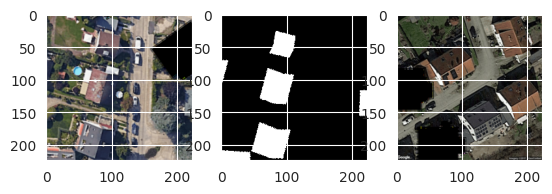

In [13]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(train_aug_images[110])
axs[1].imshow(train_aug_labels[110].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[0])
plt.show()

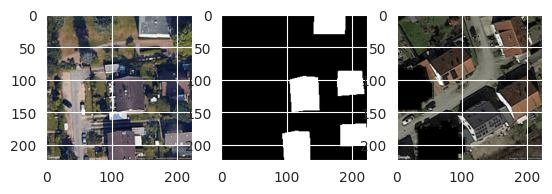

In [14]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(processed_train_images[0])
axs[1].imshow(processed_train_labels[0].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[0])
plt.show()

## Training Models with Various Architectures

### Base CNN Model: Trained From Scratch

In [15]:
# Define the CNN model
def CNN(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
    input_shape = input_size
    model = Sequential(name='CNN')
    # Downsampling, Encoding 
    model.add(Conv2D(n_filters*2, (5, 5), activation='relu', input_shape=input_shape, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(n_filters*4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(n_filters*8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(n_filters*16, (3, 3), activation='relu', padding='same'))

    # Upsampling, Decoding
    model.add(Conv2DTranspose(n_filters*8, (4, 4), strides=(2, 2), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2DTranspose(n_filters*4, (4, 4), strides=(2, 2), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2DTranspose(n_filters*2, (4, 4), strides=(2, 2), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(n_filters*4, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(n_classes, (3, 3), activation='sigmoid', padding='same'))
    model.add(ZeroPadding2D(padding=((4, 4), (4, 4))))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### Loading the training the CNN model without augmented images

In [ ]:
# Define the model
cnn = CNN()

# Get the model info
## model_info(cnn)

# Getting images
imgs = img('normal')

# Train the model
h_cnn = cnn.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

# Storing the history 
model_histories['cnn'] = h_cnn

# Plotting the accuracy and loss for train and validation data
# We see all plots together at the end
# acc_loss_plot(h_cnn) 

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(cnn)

In [ ]:
# Predictions on the test set
test_predictions(cnn,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Normal Images
cv_cnn = CNN()
cv(cv_cnn, 5,'normal')

#### Loading the training the CNN model with augmented images

In [ ]:
# Define the model
aug_cnn = CNN()

# Compile the model and train it
#aug_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Getting images
imgs = img('augmented')

# Train the model
h_aug_cnn = aug_cnn.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))
model_histories['aug_cnn'] = h_aug_cnn

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_aug_cnn)

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_cnn)

In [ ]:
# Predictions on the test set
test_predictions(aug_cnn,tprs,fprs)

Fold 1:
Validation accuracy: 91.25969409942627%
Validation Loss: 25.991272926330566%
Fold 2:
Validation accuracy: 94.65367794036865%
Validation Loss: 19.331564009189606%
Fold 3:
Validation accuracy: 87.14503645896912%
Validation Loss: 31.90452754497528%
Fold 4:
Validation accuracy: 96.48195505142212%
Validation Loss: 15.461607277393341%
Fold 5:
Validation accuracy: 95.95651626586914%
Validation Loss: 20.57662457227707%


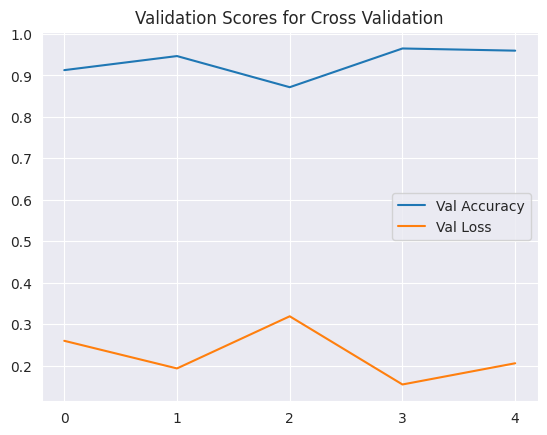

In [ ]:
# Observing the results of 5-fold Cross_Validation with Augmented Images
cv_cnn = CNN()
cv(aug_cnn, 5,'augmented')

### Base UNET: Trained From Scratch

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
  conv = Conv2D(n_filters, 
                3,  # filter size
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(inputs)
  conv = Conv2D(n_filters, 
                3,  # filter size
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(conv)

  conv = BatchNormalization()(conv, training=False)
  if dropout_prob > 0:     
      conv = tf.keras.layers.Dropout(dropout_prob)(conv)
  if max_pooling:
      next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
  else:
      next_layer = conv
  
  skip_connection = conv    
  return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
  up = Conv2DTranspose(
                n_filters,
                (3,3),
                strides=(2,2),
                padding='same')(prev_layer_input)
  merge = concatenate([up, skip_layer_input],axis = 3)
  conv = Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(merge)
  conv = Conv2D(n_filters,
                3, 
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(conv)
  return conv

In [ ]:
# Defining the UNET using the encoder and decoder functions
def UNet(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):

  # Input size represent the size of 1 image (the size used for pre-processing)
  inputs = Input(input_size)

  # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
  # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
  # keeping dropout to be 0 becaue we have small dataset itself
  cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
  cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
  cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
  cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=dropout_prob, max_pooling=True)
  cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=dropout_prob, max_pooling=False) 

  # Decoder includes multiple mini blocks with decreasing number of filters
  # Observe the skip connections from the encoder are given as input to the decoder
  # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
  ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

  # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
  # Followed by a 1x1 Conv layer to get the image to the desired size. 
  # Observe the number of channels will be equal to number of output classes
  conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes, 1, padding='same', activation = 'sigmoid')(conv9)

  # Define the model
  model = Model(inputs=inputs, outputs=conv10,name = 'UNET')
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

#### Loading the training the UNET model without augmented images

In [ ]:
# Define the model
unet = UNet()

# Getting images
imgs = img('normal')

# Train the model
h_unet = unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))
model_histories['unet'] = h_unet

# Plotting the accuracy and loss for train and validation data
# acc_loss_plot(h_unet)

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(unet)

In [ ]:
# Predictions on the test set
test_predictions(unet,tprs,fprs)

In [ ]:
# Observing the results of 5-fold Cross_Validation with Normal Images
cv_unet = UNet()
cv(cv_unet, 5,'normal')

#### Loading the training the model with augmented images

In [ ]:
# Define the model
aug_unet = UNet()

# Compile the model and train it
#aug_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Getting images
imgs = img('augmented')

# Train the model
h_aug_unet = aug_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))
model_histories['aug_unet'] = h_aug_unet

In [ ]:
# Plotting the accuracy and loss for train and validation data
acc_loss_plot(h_aug_unet)

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_unet)

In [ ]:
# Predictions on the test set
test_predictions(aug_unet,tprs,fprs)

In [ ]:
cv_unet = UNet()
cv(cv_unet, 5,'augmented')

In [ ]:
# # Define the hyperparameter grid
# param_grid = {
#     'n_filters': [16, 32],
#     'dropout_prob': [0.1, 0.2, 0.3],
#     'batch_size': [3, 5, 10],
#     'epochs': [10, 15,20],
#     'learning_rate':[0.001, 0.01]
# }

# # Define the model function for use with KerasRegressor
# def create_model(n_filters=16, dropout_prob=0, input_size=(224, 224, 3)):
#     model = UNetCompiled(input_size=input_size, n_filters=n_filters, dropout_prob=dropout_prob)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Wrap the model function with KerasRegressor
# keras_model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define the GridSearchCV object with the hyperparameter grid and the wrapped Keras model
# grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, n_jobs=-1)

# # Perform the search
# grid_result = grid_search.fit(processed_train_images,processed_train_labels, validation_data=(processed_val_images,processed_val_labels))

# # Print the best hyperparameters and corresponding score
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

### Fine Tuned VGG16 and combined with Unet

In [ ]:
conv1 = ['block1_conv1','block1_conv2']
conv2 = ['block2_conv1','block2_conv2']
conv3 = ['block3_conv1','block3_conv2','block3_conv3']
conv4 = ['block4_conv1','block4_conv2','block4_conv3']
conv5 = ['block5_conv1','block5_conv2','block5_conv3']
pool1 = ['block1_pool']
pool2 = ['block2_pool']
pool3 = ['block3_pool']
pool4 = ['block4_pool']
pool5 = ['block5_pool']

## Observing the layers of the model
# VGG16 = vgg16.VGG16(include_top = False, weights = 'imagenet',input_shape = (224,224,3))
# train_layers =  conv5 
# non_train_layers = ['input_21']+pool1 + pool2 + pool3 + pool4 + pool5+conv1 + conv2  + conv3 + conv4
# for layer in VGG16.layers:
#   if layer.name in train_layers:
#     layer.trainable = True
#   if layer.name in non_train_layers:
#     layer.trainable = False
# layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in VGG16.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
  up = Conv2DTranspose(n_filters, (3, 3), 
                       strides=(2, 2),
                       padding='same',
                       activation=LeakyReLU(0.1), 
                       kernel_initializer='he_normal')(prev_layer_input)
  up = BatchNormalization()(up)
  merge = concatenate([up, skip_layer_input],axis = 3)
  conv = Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')(merge)
  # conv = Conv2D(n_filters,
  #               3, 
  #               activation='relu',
  #               padding='same',
  #               kernel_initializer='HeNormal')(conv)
  return conv

In [ ]:
def Vgg_Unet(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  VGG16 = vgg16.VGG16(include_top = False, weights = 'imagenet',input_shape = input_size)
  last_layer = VGG16.output

  set_trainable = False

  train_layers =  conv5 
  non_train_layers = ['input_21'] + pool1 + pool2 + pool3 + pool4 + pool5+conv1 + conv2  + conv3 + conv4

  for layer in VGG16.layers:
    if layer.name in train_layers:
      layer.trainable = True
    if layer.name in non_train_layers:
      layer.trainable = False
  
  
  last_layer = VGG16.output
  unet = DecoderMiniBlock(last_layer,VGG16.get_layer("block5_conv3").output, n_filters*32)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block4_conv3").output, n_filters*32)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block3_conv3").output, n_filters*16)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block2_conv2").output, n_filters*8)
  unet = DecoderMiniBlock(unet,VGG16.get_layer("block1_conv2").output, n_filters*4)

  conv9 = Conv2D(n_filters*2,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(unet)
  conv10 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv9)

  conv11 = Conv2D(n_classes,
                1,
                activation='sigmoid',
                padding='same',
                kernel_initializer='he_normal')(unet)

  model = Model(VGG16.input,conv11)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

#### Loading and training the model without augmented images

In [ ]:
# Define the model
vgg_unet = Vgg_Unet()

# Compile the model and train it
#vgg_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Getting images
imgs = img('normal')

# Train the model
h_vgg_unet = vgg_unet.fit(imgs[0],imgs[1],epochs=30, batch_size=5, validation_data = (imgs[2],imgs[3]))

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/30
4/4 [==============================] - 15s 338ms/step - loss: 1.0144 - accuracy: 0.7380 - val_loss: 2.5811 - val_accuracy: 0.6471
Epoch 2/30
4/4 [==============================] - 1s 214ms/step - loss: 0.5376 - accuracy: 0.8756 - val_loss: 50.3068 - val_accuracy: 0.2234
Epoch 3/30
4/4 [==============================] - 1s 212ms/step - loss: 0.2154 - accuracy: 0.9294 - val_loss: 30.4736 - val_accuracy: 0.5757
Epoch 4/30
4/4 [==============================] - 1s 215ms/step - loss: 0.1550 - accuracy: 0.9477 - val_loss: 455.1949 - val_accuracy: 0.1507
Epoch 5/30
4/4 [==============================] - 1s 211ms/step - loss: 0.1129 - accuracy: 0.9588 - val_loss: 97.6374 - val_accuracy: 0.1636
Epoch 6/30
4/4 [==============================] - 1s 213ms/step - loss: 0.0850 - accuracy: 0.9670 - val_loss: 65.8857 - val_accuracy: 0.1892
Epoch 7/30
4/4 [==============================] - 1s 216ms/step - loss: 0.0645 - accurac

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(vgg_unet, to_file='UNET with VGG16.png', show_shapes=True, rankdir='TB')
# layers = [(layer, layer.name, layer.trainable,layer.output.shape) for layer in vgg_unet.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

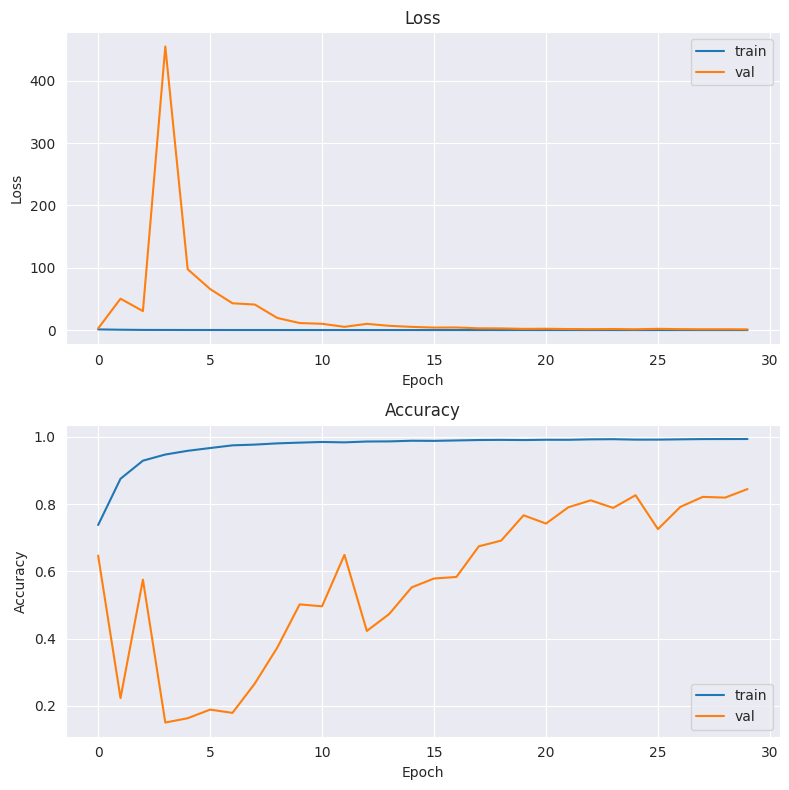

In [ ]:
# Plotting the accuracy and loss for train and validation data
acc_loss_plot(h_vgg_unet)

1/1 [==============================] - 0s 294ms/step


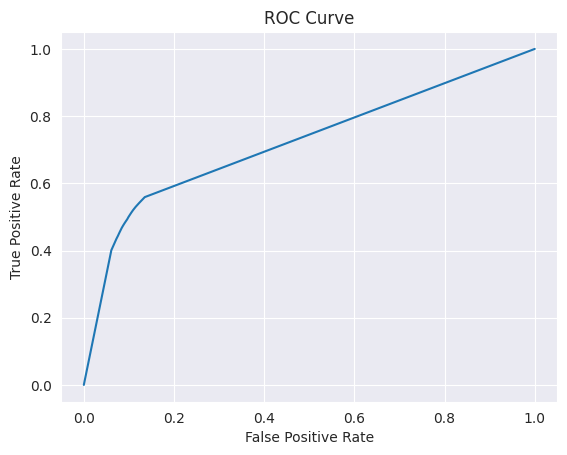

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(vgg_unet)

1/1 [==============================] - 0s 25ms/step


Predictions for best threshold value: 0.05


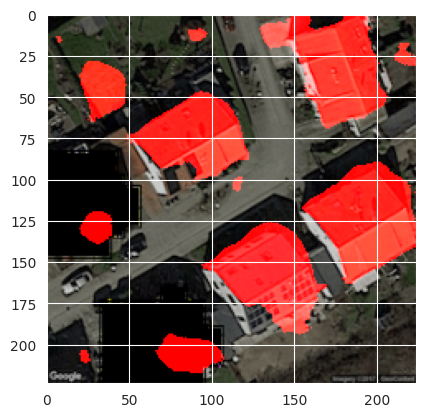

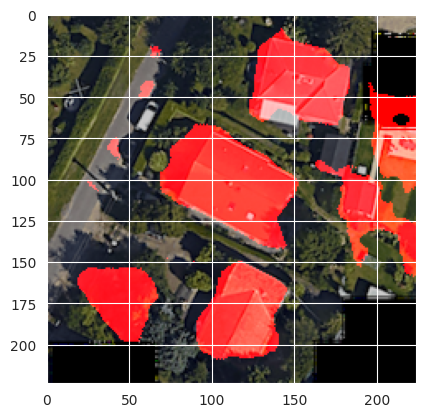

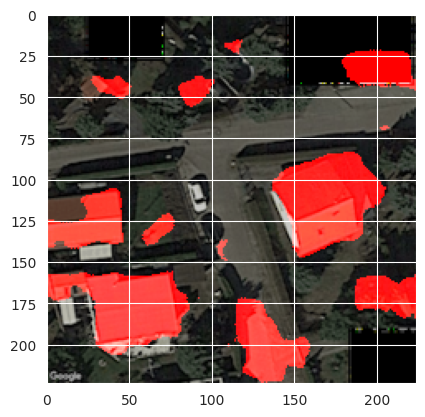

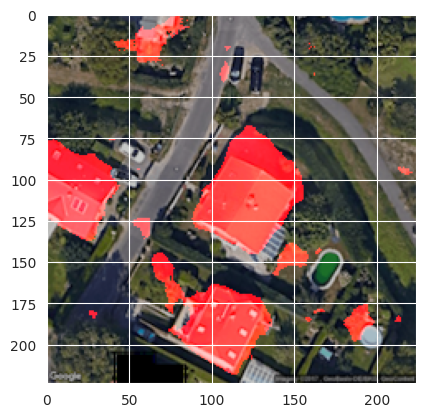

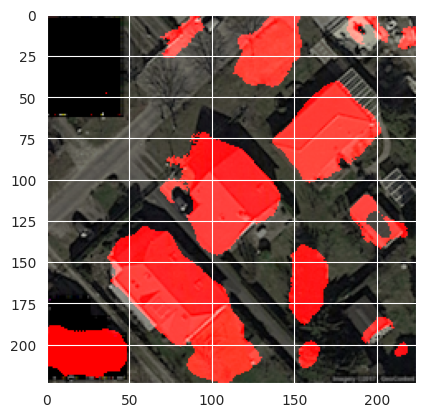

In [ ]:
# Predictions on the test set
test_predictions(vgg_unet,tprs,fprs)

Fold 1:
Validation accuracy: 99.12657737731934%
Validation Loss: 2.247634157538414%
Fold 2:
Validation accuracy: 98.80221486091614%
Validation Loss: 3.14316488802433%
Fold 3:
Validation accuracy: 96.41262888908386%
Validation Loss: 11.330783367156982%
Fold 4:
Validation accuracy: 99.49278831481934%
Validation Loss: 1.2462870217859745%
Fold 5:
Validation accuracy: 99.66866374015808%
Validation Loss: 0.8127057924866676%


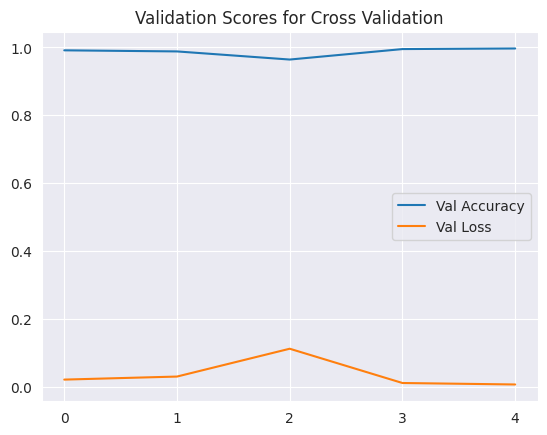

In [ ]:
cv_vgg_unet = Vgg_Unet()
cv(vgg_unet, 5,'normal')

#### Loading and training the model with augmented images

In [ ]:
# Define the model
aug_vgg_unet = Vgg_Unet()

# Compile the model and train it
#aug_vgg_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Getting images
imgs = img('augmented')

# Train the model
h_aug_vgg_unet = aug_vgg_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

Epoch 1/15
28/28 [==============================] - 12s 229ms/step - loss: 0.2947 - accuracy: 0.8975 - val_loss: 13.0458 - val_accuracy: 0.6483
Epoch 2/15
28/28 [==============================] - 6s 205ms/step - loss: 0.1136 - accuracy: 0.9561 - val_loss: 5.7184 - val_accuracy: 0.4982
Epoch 3/15
28/28 [==============================] - 6s 206ms/step - loss: 0.0855 - accuracy: 0.9665 - val_loss: 2.9933 - val_accuracy: 0.5146
Epoch 4/15
28/28 [==============================] - 6s 205ms/step - loss: 0.0606 - accuracy: 0.9764 - val_loss: 1.0290 - val_accuracy: 0.8709
Epoch 5/15
28/28 [==============================] - 6s 205ms/step - loss: 0.0459 - accuracy: 0.9819 - val_loss: 0.8103 - val_accuracy: 0.8802
Epoch 6/15
28/28 [==============================] - 6s 208ms/step - loss: 0.0434 - accuracy: 0.9830 - val_loss: 0.8508 - val_accuracy: 0.8750
Epoch 7/15
28/28 [==============================] - 6s 205ms/step - loss: 0.0368 - accuracy: 0.9855 - val_loss: 0.7872 - val_accuracy: 0.8781
Epoc

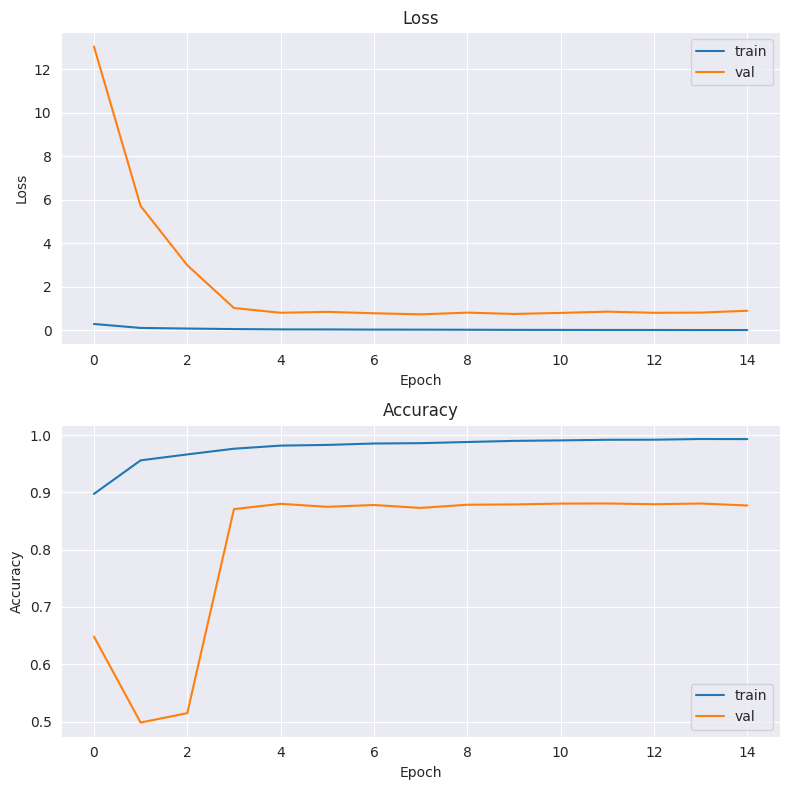

In [ ]:
# Plotting the accuracy and loss for train and validation data
acc_loss_plot(h_aug_vgg_unet)

1/1 [==============================] - 0s 437ms/step


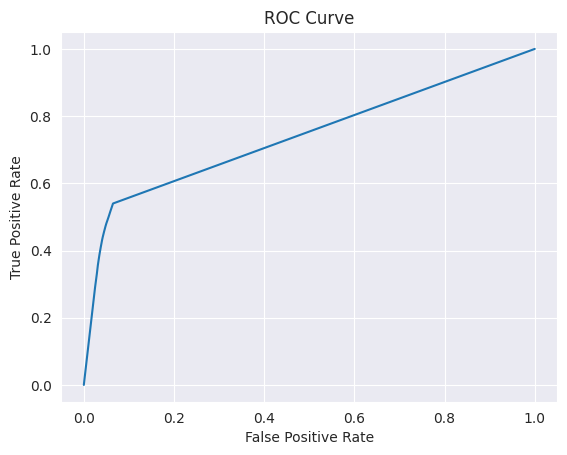

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_vgg_unet)

1/1 [==============================] - 0s 38ms/step


Predictions for best threshold value: 0.05


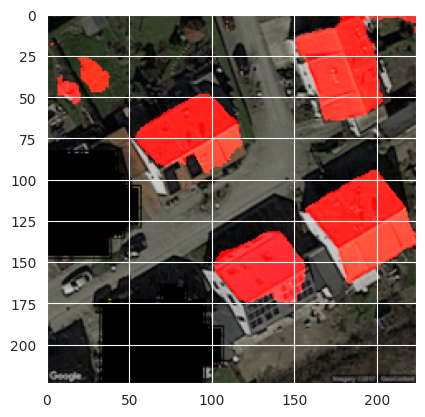

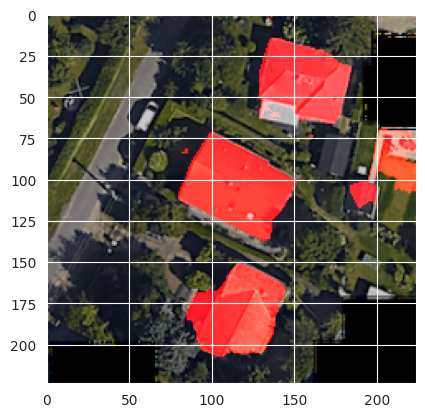

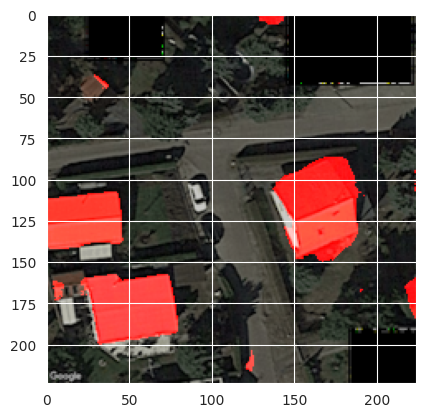

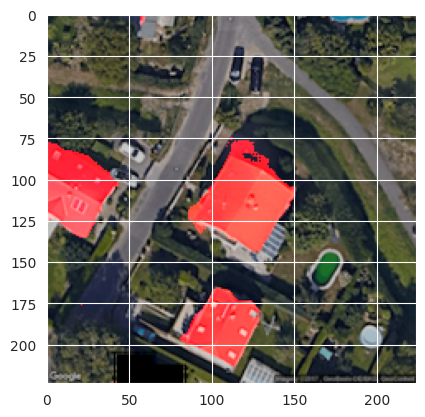

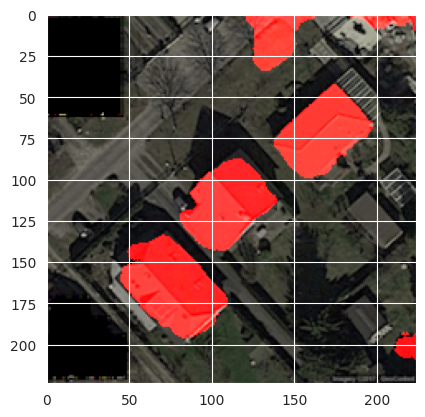

In [ ]:
# Predictions on the test set
test_predictions(aug_vgg_unet,tprs,fprs)

Fold 1:
Validation accuracy: 95.28160691261292%
Validation Loss: 22.21504896879196%
Fold 2:
Validation accuracy: 98.84641766548157%
Validation Loss: 3.2618530094623566%
Fold 3:
Validation accuracy: 99.36736822128296%
Validation Loss: 1.7223834991455078%
Fold 4:
Validation accuracy: 99.6357798576355%
Validation Loss: 0.925589632242918%
Fold 5:
Validation accuracy: 99.74475502967834%
Validation Loss: 0.634580384939909%


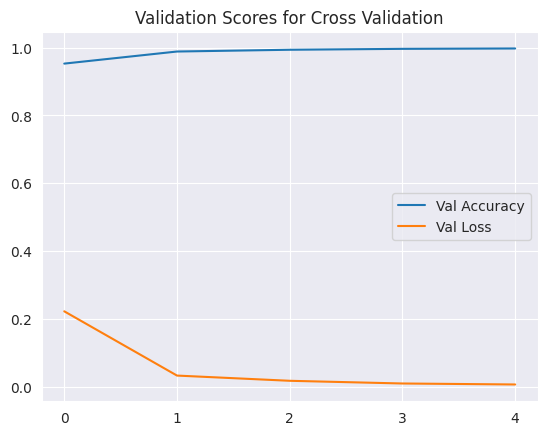

In [ ]:
cv_vgg_unet = Vgg_Unet()
cv(cv_vgg_unet, 5,'augmented')

### Fine Tuned MobileNet and combined with Unet

In [ ]:
, optimizer
def mobunet_model(input_size=(224, 224, 3), n_filters=16, n_classes=1,dropout_prob = 0):
  base_model = MobileNetV2(input_shape=[224, 224, 3], include_top=False)

##################

  # Use the activations of these layers
  layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
  down_stack.trainable = False

    ##################

  up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    ##################

  inputs = Input(shape=input_size)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Append another Conv2DTranspose layer with appropriate parameters
  x = tf.keras.layers.Conv2DTranspose(
      filters=64, kernel_size=3, strides=2,
      padding='same')(x)

  x = tf.keras.layers.Conv2D(
      filters=1, kernel_size=1, strides=1,
      padding='valid')(x)
    
  # x = tf.keras.layers.Cropping2D(cropping=96)(x)
    
  x = tf.keras.activations.sigmoid(x)
  x = Model(inputs = inputs, outputs = x)
  x.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return x

#### Loading and training the model without augmented images

In [ ]:
# Define the model
mob_unet = mobunet_model()

# Compile the model and train it
#mob_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Getting images
imgs = img('normal')

# Train the model
h_mob_unet = mob_unet.fit(imgs[0],imgs[1],epochs=30, batch_size=5, validation_data = (imgs[2],imgs[3]))

Epoch 1/30
4/4 [==============================] - 6s 381ms/step - loss: 0.5387 - accuracy: 0.8104 - val_loss: 0.4890 - val_accuracy: 0.8478
Epoch 2/30
4/4 [==============================] - 0s 75ms/step - loss: 0.4227 - accuracy: 0.8499 - val_loss: 0.4548 - val_accuracy: 0.8500
Epoch 3/30
4/4 [==============================] - 0s 74ms/step - loss: 0.2875 - accuracy: 0.9000 - val_loss: 0.4813 - val_accuracy: 0.8100
Epoch 4/30
4/4 [==============================] - 0s 74ms/step - loss: 0.2013 - accuracy: 0.9283 - val_loss: 0.5296 - val_accuracy: 0.8113
Epoch 5/30
4/4 [==============================] - 0s 74ms/step - loss: 0.1494 - accuracy: 0.9458 - val_loss: 0.5207 - val_accuracy: 0.8295
Epoch 6/30
4/4 [==============================] - 0s 61ms/step - loss: 0.1154 - accuracy: 0.9580 - val_loss: 0.5267 - val_accuracy: 0.8495
Epoch 7/30
4/4 [==============================] - 0s 75ms/step - loss: 0.1009 - accuracy: 0.9631 - val_loss: 0.5946 - val_accuracy: 0.8437
Epoch 8/30
4/4 [==========

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(mob_unet, to_file='UNET_Mob.png', show_shapes=True, rankdir='TB')
# layers = [(layer, layer.name, layer.trainable,layer.output) for layer in mob_unet.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable', 'Layer Op'])

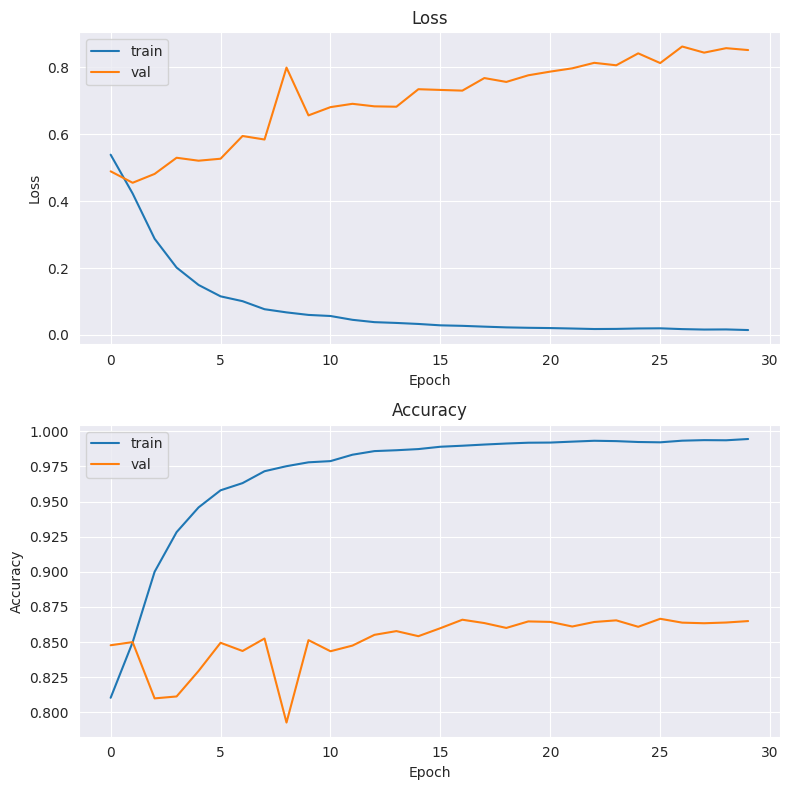

In [ ]:
# Plotting the accuracy and loss for train and validation data
acc_loss_plot(h_mob_unet)

1/1 [==============================] - 1s 1s/step


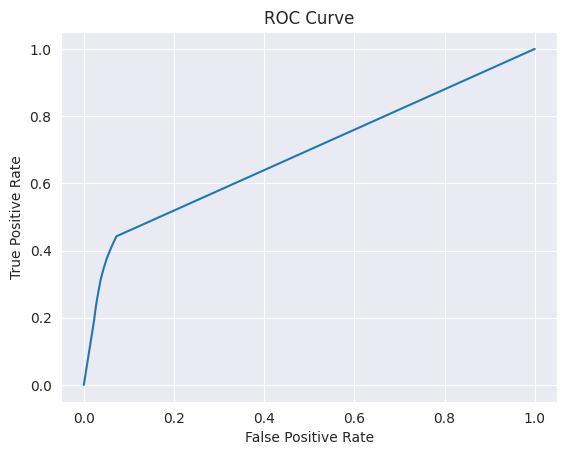

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(mob_unet)

1/1 [==============================] - 0s 36ms/step


Predictions for best threshold value: 0.05


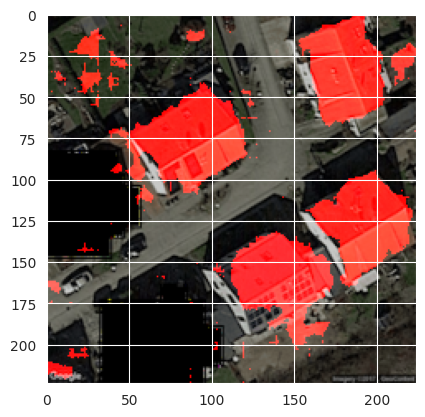

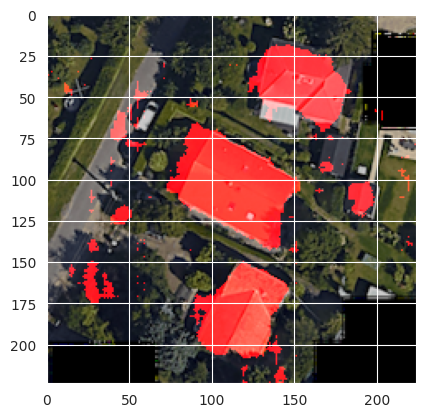

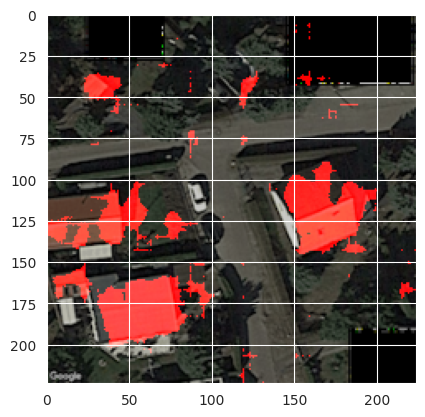

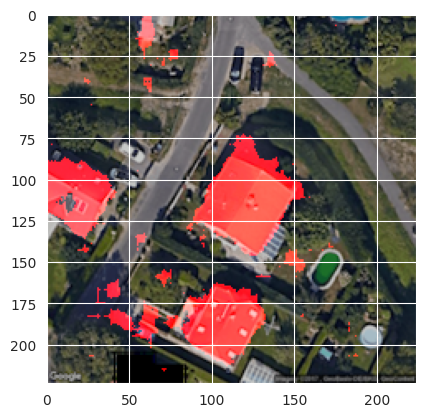

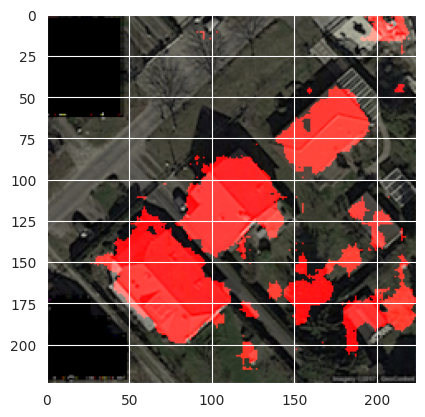

In [ ]:
# Predictions on the test set
test_predictions(mob_unet,tprs,fprs)

Fold 1:
Validation accuracy: 92.86959767341614%
Validation Loss: 25.869622826576233%
Fold 2:
Validation accuracy: 97.36477732658386%
Validation Loss: 7.470446825027466%
Fold 3:
Validation accuracy: 98.52319955825806%
Validation Loss: 3.899669274687767%
Fold 4:
Validation accuracy: 99.17590022087097%
Validation Loss: 2.1030426025390625%
Fold 5:
Validation accuracy: 99.4160532951355%
Validation Loss: 1.502874679863453%


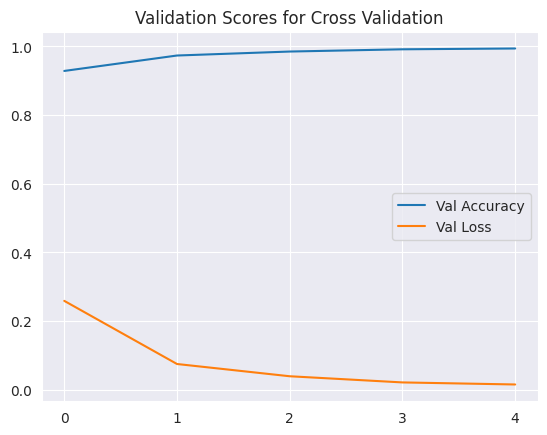

In [ ]:
cv_mob_unet = mobunet_model()
cv(cv_mob_unet, 5,'normal')

#### Loading and training the model with augmented images

In [ ]:
# Define the model
aug_mob_unet = mobunet_model()

# Compile the model and train it
#aug_mob_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Getting images
imgs = img('augmented')

# Train the model
h_aug_mob_unet = aug_mob_unet.fit(imgs[0],imgs[1],epochs=15, batch_size=5, validation_data = (imgs[2],imgs[3]))

Epoch 1/15
28/28 [==============================] - 7s 93ms/step - loss: 0.3583 - accuracy: 0.8759 - val_loss: 0.6313 - val_accuracy: 0.8048
Epoch 2/15
28/28 [==============================] - 2s 61ms/step - loss: 0.1453 - accuracy: 0.9448 - val_loss: 0.8902 - val_accuracy: 0.7610
Epoch 3/15
28/28 [==============================] - 2s 61ms/step - loss: 0.1177 - accuracy: 0.9540 - val_loss: 0.7678 - val_accuracy: 0.7848
Epoch 4/15
28/28 [==============================] - 1s 53ms/step - loss: 0.1003 - accuracy: 0.9611 - val_loss: 0.6042 - val_accuracy: 0.8512
Epoch 5/15
28/28 [==============================] - 1s 52ms/step - loss: 0.0834 - accuracy: 0.9681 - val_loss: 0.6488 - val_accuracy: 0.8441
Epoch 6/15
28/28 [==============================] - 1s 53ms/step - loss: 0.0839 - accuracy: 0.9675 - val_loss: 0.6455 - val_accuracy: 0.8629
Epoch 7/15
28/28 [==============================] - 1s 53ms/step - loss: 0.0700 - accuracy: 0.9730 - val_loss: 0.7129 - val_accuracy: 0.8364
Epoch 8/15
28

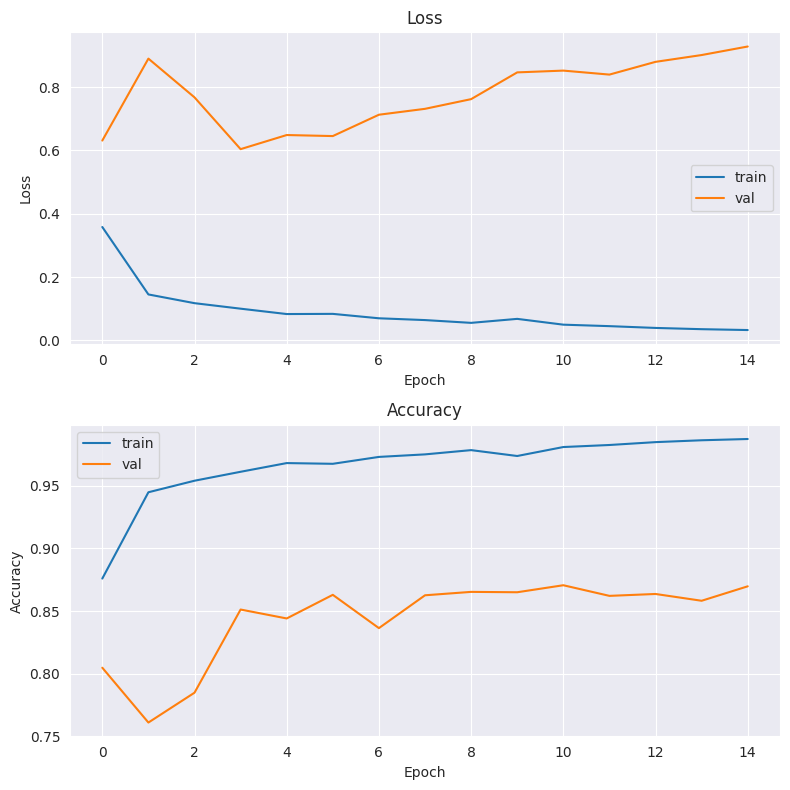

In [ ]:
# Plotting the accuracy and loss for train and validation data
acc_loss_plot(h_aug_mob_unet)

1/1 [==============================] - 1s 778ms/step


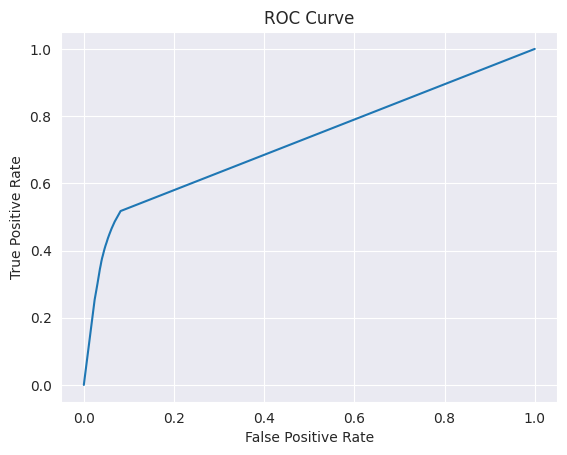

In [ ]:
# Plotting the ROC curve
tprs,fprs = roc_curve(aug_mob_unet)

1/1 [==============================] - 0s 28ms/step


Predictions for best threshold value: 0.05


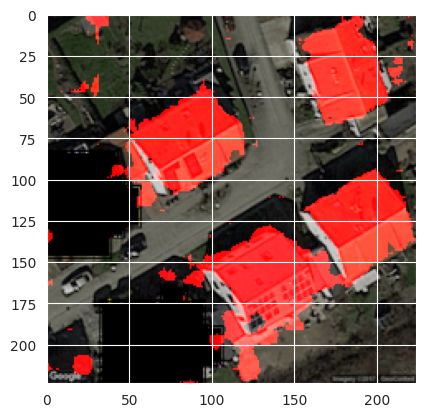

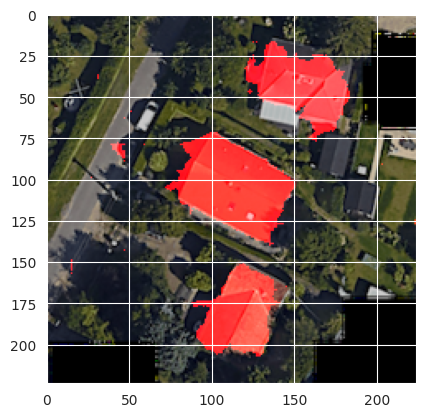

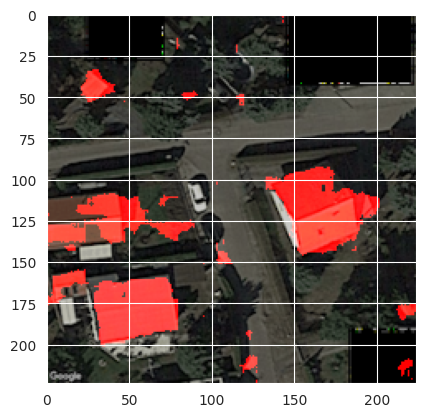

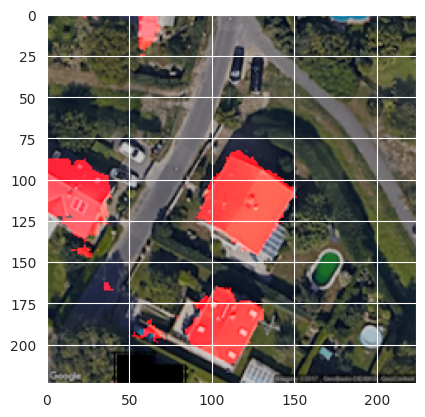

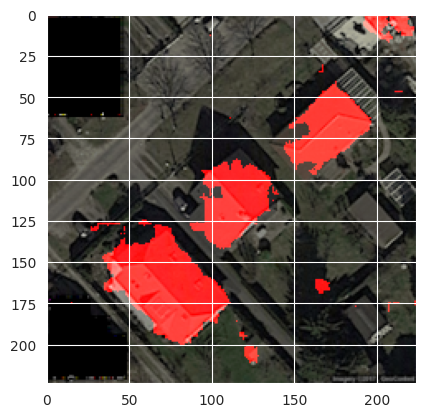

In [ ]:
# Predictions on the test set
test_predictions(aug_mob_unet,tprs,fprs)

Fold 1:
Validation accuracy: 93.96694898605347%
Validation Loss: 25.868481397628784%
Fold 2:
Validation accuracy: 96.67078852653503%
Validation Loss: 11.231498420238495%
Fold 3:
Validation accuracy: 99.25469756126404%
Validation Loss: 2.0411524921655655%
Fold 4:
Validation accuracy: 99.55655932426453%
Validation Loss: 1.1599726043641567%
Fold 5:
Validation accuracy: 99.75535869598389%
Validation Loss: 0.6270871497690678%


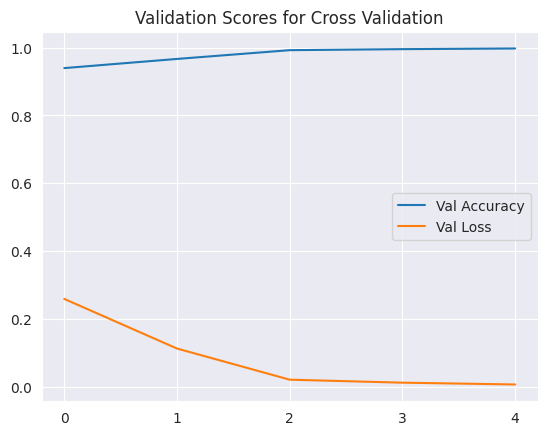

In [ ]:
cv_mob_unet = mobunet_model()
cv(cv_mob_unet, 5,'augmented')

### Random Forest Classifier

In [ ]:
# %cd /content/gdrive/MyDrive/images/dida_task_dummy

In [ ]:
# X = []
# # path = train_image_path
# # file = '22.png'
# # image_path = os.path.join(path, file)
# # image = cv2.imread(image_path)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # resized_image = resize(image, (224,224))
# # X.append(resized_image)


# img_path = "22.png"
# path = os.path.join(train_image_path, img_path)
# img = cv2.imread(path)
# img = cv2.resize(img, (224, 224))  # resize image
# X.append(img)

In [ ]:
# # Load images and labels
# X = []  # images
# y = []  # labels
# image_path = './train/images/'
# label_path = './train/labels/'
# imgs = sorted(os.listdir(image_path))
# for i in imgs:
#     # Load image
#     img_path = image_path + i
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (224, 224))  # resize image
#     X.append(img)

#     # Load label
#     lab_path = label_path + i
#     label = cv2.imread(lab_path, cv2.IMREAD_GRAYSCALE)
#     label = cv2.resize(label, (224, 224), cv2.INTER_NEAREST)  # resize label using nearest neighbor interpolation
#     label = np.where(label > 0, 1, 0)  # binarize label
#     y.append(label)
# # Convert data to numpy arrays
# X = np.array(X)
# y = np.array(y)

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=42)

# # Reshape data for training
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)
# y_train = y_train.reshape(y_train.shape[0], -1)
# y_test = y_test.reshape(y_test.shape[0], -1)

In [ ]:
# X_train.shape,y_train.shape

In [ ]:
# # Train a random forest classifier
# rfc = RandomForestClassifier(n_estimators=10, random_state=42, verbose =1, n_jobs = 2 )
# hrfc=rfc.fit(X_train, y_train)
# y_pred = rfc.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print("Random forest accuracy:", acc)

In [ ]:
# # Train a gradient boosted tree classifier
# gbt = GradientBoostingClassifier(n_estimators=100, random_state=42, verbose = 1)
# hgbt = gbt.fit(X_train, y_train)
# y_pred = gbt.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print("Gradient boosted tree accuracy:", acc)